In [1]:
%matplotlib inline
import sys
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")

import matplotlib.pyplot as plt
import numpy as np

from icglm.vglm import VGLM
from icglm.kernels import KernelRect
from icglm.processes import OUProcess

%load_ext autoreload
%autoreload 2

In [2]:
t = np.arange(0, 100000, 1)
mu, sd = 25, 25
ou = OUProcess(mu=mu, sd=sd, tau=3)
stim = ou.sample(t, seed=0)

u0 = 50
kappa = KernelRect.exponential(tf=240, dt=8, tau=40, A=1e-2)
eta = KernelRect.exponential(tf=450, dt=25, tau=75, A=7)
gamma = KernelRect.exponential(tf=225, dt=25, tau=25, A=20)
vt, dv = -30, 1
vglm_true = VGLM(u0=u0, kappa=kappa, eta=eta, vt=vt, dv=dv, gamma=gamma)

np.random.seed(0)
v, r, mask_spk_true = vglm_true.sample(t, stim)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 10), nrows=3)
ax1.plot(t, mask_spk_true)
ax2.plot(t, r)
ax3.plot(t, v)

TypeError: __init__() got an unexpected keyword argument 'u0'

dict_keys(['data', 'mask_subthreshold'])
dict_keys(['X_spikes', 'X', 'X_sub', 'data_sub', 'Y_spikes', 'Y'])
Starting gradient ascent... 

 Iteration 6 of 30 | Elapsed time: 3.7 seconds | log_prior=nan | log_posterior=-746.97
 
 Iteration 6 of 30 | Converged | Elapsed time: 0.0617 minutes | Log posterior is monotonic 

u0 50 49.999257115133105
vt -30 -29.120376289185906
dv 1 1.026099815378732
[-748.1998465  -748.05577271 -747.49197195 -747.43143303 -747.37599985
 -747.32519707 -746.96714862]


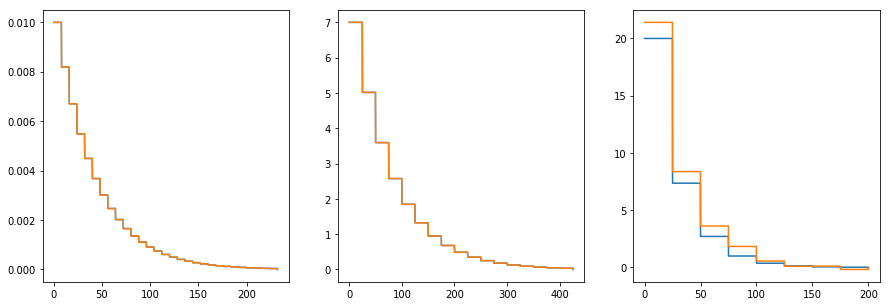

In [8]:
theta0 = np.concatenate((np.array([u0]), kappa.coefs * 1, eta.coefs * 1, [vt], gamma.coefs, [1]))
newton_kwargs = dict(max_iterations=30, stop_cond=5e-4, learning_rate=5e-1, initial_learning_rate=5e-2, warm_up_iterations=5)

mask_subthreshold = np.ones(mask_spk_true.shape, dtype=bool)
mask_subthreshold[mask_spk_true] = False
vglm = vglm_true.copy()
optimizer = vglm.fit(t, stim, mask_spk_true, data=v, mask_subthreshold=mask_subthreshold, theta0=theta0, newton_kwargs=newton_kwargs,verbose=True)
print('u0', vglm_true.u0, vglm.u0)
print('vt', vglm_true.vt, vglm.vt)
print('dv', vglm_true.dv, vglm.dv)
print(optimizer.log_posterior_iterations)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)
vglm_true.kappa.plot(ax=ax1)
vglm.kappa.plot(ax=ax1)
vglm_true.eta.plot(ax=ax2)
vglm.eta.plot(ax=ax2)
vglm_true.gamma.plot(ax=ax3)
vglm.gamma.plot(ax=ax3)
# ax3.plot(optimizer.log_posterior_iterations, '-o')